In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)
print(left_bnd_nodes_idx)
print(right_bnd_nodes_idx)

[0, 12, 15, 18, 3]
[7, 34, 37, 40, 9]
[0, 3, 16, 17, 18, 19]
[1, 2, 8, 9, 10, 11]


In [6]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, 0]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
up_bnd_pos = np.zeros((len(up_bnd_nodes_idx), 3))
up_bnd_pos[:,0] = up_bnd_nodes_pos_x
up_bnd_pos[:,1] = up_bnd_nodes_pos_y
print(up_bnd_pos)
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]
print(down_bnd_pos)
left_bnd_pos = true_curr_node_coords[left_bnd_nodes_idx, :]
right_bnd_pos = true_curr_node_coords[right_bnd_nodes_idx, :]
print(np.vstack((left_bnd_pos, right_bnd_pos)))

[[1.2 1.  0. ]
 [0.2 1.  0. ]
 [1.  1.  0. ]
 [0.8 1.  0. ]
 [0.6 1.  0. ]
 [0.4 1.  0. ]]
[[0.  0.  0. ]
 [1.  0.  0. ]
 [0.2 0.  0. ]
 [0.4 0.  0. ]
 [0.6 0.  0. ]
 [0.8 0.  0. ]]
[[0.   0.   0.  ]
 [0.2  1.   0.  ]
 [0.16 0.8  0.  ]
 [0.12 0.6  0.  ]
 [0.08 0.4  0.  ]
 [0.04 0.2  0.  ]
 [1.   0.   0.  ]
 [1.2  1.   0.  ]
 [1.04 0.2  0.  ]
 [1.08 0.4  0.  ]
 [1.12 0.6  0.  ]
 [1.16 0.8  0.  ]]


In [7]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
#boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
#                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
bnodes = left_bnd_nodes_idx + right_bnd_nodes_idx + up_bnd_nodes_idx + down_bnd_nodes_idx
bvalues = np.vstack((left_bnd_pos, right_bnd_pos, up_bnd_pos, down_bnd_pos))
boundary_values = {":": (bnodes, bvalues)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
#f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
#curr_node_coords = jnp.full(
#    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
obj = ela.obj_linear_elasticity_energy
#obj = ela.obj_linear_elasticity_primal
x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

#unknown_node_coords = S.node_coords.copy()
#unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
#unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
#unknown_node_coords_flattened = unknown_node_coords.flatten()
#unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
#x0 = unknown_node_coords_flattened[unknown_node_idx]
#obj = partial(ela.obj_linear_elasticity_dual,
#                          unknown_node_idx=unknown_node_idx)

# traction bcs
primal_vol_left = S.primal_volumes[1][left_bnd_edges_idx]
primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = -tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left *= primal_vol_left
#bnd_tractions_left[-1] *= -1
bnd_tractions_right = tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
#bnd_tractions_right[-1] *= -1
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))
#bnd_tractions_y = np.concatenate((bnd_tractions_left, bnd_tractions_right))

num_edges = S.S[1].shape[0]

ext_forces_coeffs = np.zeros((num_edges, 3), dtype = dt.float_dtype)
ext_forces_coeffs[left_bnd_edges_idx,1] = bnd_tractions_left
ext_forces_coeffs[right_bnd_edges_idx,1] = bnd_tractions_right
#ext_forces_coch_coeffs = np.sum(ext_forces_coeffs*S.primal_edges_vectors, axis=1)
#ext_forces = C.CochainP1(S, ext_forces_coeffs)

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'ext_forces': ext_forces_coeffs}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
#obj_args = {'f': f,
#            'boundary_values': boundary_values,
#            'boundary_tractions': boundary_tractions,
#            'curr_node_coords': curr_node_coords}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [8]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval = 20000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
#curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
#curr_node_coords_flattened = curr_node_coords.flatten()
#curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
#    curr_node_coords_flattened)].set(sol)
#curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

1


In [9]:
#print(obj(sol, f, gamma, boundary_values, boundary_tractions))
#print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))
true_node_coch = C.CochainP0(S, curr_node_coords)
f_coch = C.CochainP2(S, f)
#res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
forces = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
print(forces.coeffs[down_bnd_edges_idx,:])
#bad_coeffs =np.where(np.abs(res.coeffs[:,1]) > 1e-8)
#print(bad_coeffs)

[[ 1.34337668e-08  9.54477244e-09]
 [ 7.67660442e-09 -5.50243975e-10]
 [ 1.42055221e-09  2.89502158e-08]
 [ 1.06308698e-08 -1.31804177e-08]
 [ 2.34589809e-08 -1.43748179e-08]]


In [15]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 4.75365680e-09  9.99999992e-02]
  [ 9.99999992e-02 -2.73489509e-09]]

 [[-1.58108058e-08  9.99999850e-02]
  [ 9.99999850e-02 -8.08376255e-10]]

 [[ 3.72967213e-10  1.00000004e-01]
  [ 1.00000004e-01  2.05448480e-09]]

 [[-4.00190425e-09  9.99999998e-02]
  [ 9.99999998e-02  2.03394368e-09]]

 [[ 4.12731627e-10  1.00000003e-01]
  [ 1.00000003e-01 -2.05440454e-09]]

 [[-4.50349269e-09  1.00000002e-01]
  [ 1.00000002e-01  1.90452076e-09]]

 [[ 3.21926841e-09  1.00000001e-01]
  [ 1.00000001e-01 -2.43879772e-09]]

 [[ 1.86235027e-10  1.00000003e-01]
  [ 1.00000003e-01 -2.05217554e-09]]

 [[ 3.23715721e-10  1.00000004e-01]
  [ 1.00000004e-01  1.82512694e-09]]

 [[ 3.05418180e-09  9.99999420e-02]
  [ 9.99999420e-02 -1.68753900e-14]]

 [[ 6.21724894e-15  9.99999424e-02]
  [ 9.99999424e-02 -4.15209866e-10]]

 [[-3.14975190e-09  9.99999429e-02]
  [ 9.99999429e-02  1.59872116e-14]]

 [[-6.46043108e-10  9.99999988e-02]
  [ 9.99999988e-02  1.48111146e-09]]

 [[ 5.77315973e-15  9.99999392

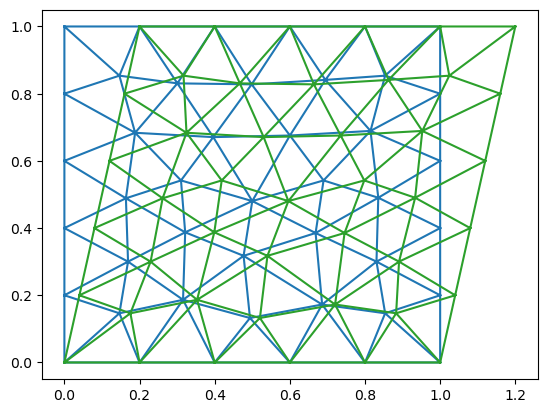

In [11]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [12]:
print(S.node_coords[S.S[2][42]])
print(S.node_coords[S.S[2][43]])
print(S.dual_volumes[0][1])
print(0.5*S.primal_volumes[2][42] + 0.5*S.primal_volumes[2][43])
print(S.primal_volumes[2][43])

[[1.         0.         0.        ]
 [1.         0.2        0.        ]
 [0.85358984 0.14641016 0.        ]]
[[0.8        0.         0.        ]
 [1.         0.         0.        ]
 [0.85358984 0.14641016 0.        ]]
0.00856406460549015
0.014641016151339628
0.014641016151362114


In [13]:
#print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))
#print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))

In [14]:
#print(true_curr_node_coords)
#print(curr_node_coords)
#print(true_curr_node_coords)
#print(curr_node_coords)
print(np.allclose(true_curr_node_coords, curr_node_coords, atol=1e-8))

True
